In [ ]:
# Can wearable sensor data predict motor tasks?
# no voluntary movement, upper-limb movement, lower-limb movement

In [1]:
# Core
import pandas as pd
import os
import numpy as np
from numpy import set_printoptions
from numpy.random import permutation
import scipy.stats as stats
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import time

#tsfresh
import tsfresh
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, EfficientFCParameters
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

# Sklearn
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
direc = "E:\\WS4PD_data"
os.chdir(direc)
save_path = os.path.join(direc, "Model_validation", "GENEActiv_tremor")

In [3]:
# Load score data
score_file_path = os.path.join(direc, 'Feature_extraction','score_by_device.pkl')
df_score = pd.read_pickle(score_file_path)

# Tremor: merge score 3 and 4
df_score['tremor_GENEActivHand'].loc[df_score['tremor_GENEActivHand']==4]=3

In [4]:
df_score

,subject_id,visit,session,task_code,repetition,tremor_GENEActivHand,tremor_PebbleHand,dyskinesia_GENEActivHand,dyskinesia_PebbleHand,bradykinesia_GENEActivHand,bradykinesia_PebbleHand
0,3_BOS,1,1,stndg,1,0,0,Yes,Yes,NotApplicable,NotApplicable
1,3_BOS,1,1,wlkgs,1,0,0,Yes,Yes,No,No
2,3_BOS,1,1,wlkgc,1,0,0,Yes,Yes,No,No
3,3_BOS,1,1,strsu,1,0,0,Yes,No,No,No
4,3_BOS,1,1,strsd,1,0,0,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...
6904,12_NYC,2,8,ntblt,1,0,0,No,No,NotApplicable,NotApplicable
6905,12_NYC,2,8,drnkg,1,0,0,No,No,No,No
6906,12_NYC,2,8,orgpa,1,0,0,No,No,No,No
6907,12_NYC,2,8,fldng,1,0,0,No,No,No,No


In [5]:
# load feature data
subject_ids = df_score.subject_id.unique()
df_feature = pd.DataFrame()
device = 'GENEActiv'
for sb in subject_ids:
    feature_file_path = os.path.join(direc,'Feature_extraction',device,sb + '_features.pkl')
    df_feature_sb = pd.read_pickle(feature_file_path)
    df_feature = pd.concat([df_feature,df_feature_sb])
df_feature = df_feature.reset_index(drop=True)

In [13]:
# load clinical features
meta_file_path = os.path.join(direc, 'Feature_extraction','metadata_features.pkl')
df_meta = pd.read_pickle(meta_file_path)

# drop subject_id and task_code 
# df_meta.drop(columns = ['subject_id', 'task_code'])
# df_meta.drop(columns = 'task_code')

# One-hot encoding clinical/ categorical features
categorical_columns = df_meta.columns
for column in categorical_columns:
    tempdf = pd.get_dummies(df_meta[column], prefix=column)
    df_meta = pd.merge(
        left=df_meta,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df_meta = df_meta.drop(columns=column)
print(df_meta.shape)

(6909, 97)


In [6]:
# Train/Validation/Test datasets

# train:validation:test = 0.5:0.25:0.25
sb_train = ['6_BOS', '16_BOS', '7_NYC', '14_BOS', '8_NYC', '5_BOS', '12_NYC', '6_NYC', '17_BOS',
           '4_BOS', '11_BOS', '10_BOS', '15_BOS', '4_NYC', '11_NYC']
sb_val = ['8_BOS', '18_BOS', '2_NYC', '9_NYC', '3_BOS', '9_BOS']
sb_test = ['19_BOS', '3_NYC', '7_BOS', '5_NYC', '13_BOS', '10_NYC', '12_BOS']


In [7]:
# task categories
task_groups = [['stndg', 'sittg'],['wlkgs', 'wlkgc', 'wlkgp', 'strsu', 'strsd', 'ststd'],
               ['ftnr', 'ftnl', 'ramr', 'raml', 'drawg', 'typng', 'ntblt', 'drnkg', 'orgpa', 'fldng']]
task_group_names = ['no_voluntary_movement','lowerlimb_movement', 'upperlimb_movement']

In [11]:
# Create a new label for each question
# 1. Can wearable sensor data predict task categories?
df_score['task_label'] = np.nan
for i,task in enumerate(task_groups):
    is_tasks = df_score['task_code'].isin(task).tolist()
    df_score['task_label'].loc[is_tasks] = i
    
title_name = 'Task group'
save_name = 'task_group'
xtick_name = [0,1,2,3]
bin_range = range(4)

In [ ]:
# Create a new label for each question

# Tremor
# 1. Can wearable sensor data predict tremor score? 
# df_score['newTremorLabel_GENEActivHand'] = df_score['tremor_GENEActivHand']
# title_name = 'Tremor score'
# save_name = 'tremor_score'
# xtick_name = [0,1,2,3,4]
# bin_range = range(5)

# 2. Can wearable sensor data predict whether tremor is present?
# is_tremor = df_score['tremor_GENEActivHand'].astype(int)>0
# df_score['newTremorLabel_GENEActivHand'] = np.nan
# df_score['newTremorLabel_GENEActivHand'].loc[is_tremor] = 1
# df_score['newTremorLabel_GENEActivHand'].loc[~is_tremor] = 0

# title_name = 'is tremor'
# save_name = 'is_tremor'
# xtick_name = [0,1]
# bin_range = range(3)

# 3. Can wearable sensor data predict whether tremor symptom is sever (score>2)? 
# is_sever_tremor = df_score['tremor_GENEActivHand'].astype(int)>2
# df_score['newTremorLabel_GENEActivHand'] = np.nan
# df_score['newTremorLabel_GENEActivHand'].loc[is_sever_tremor] = 1
# df_score['newTremorLabel_GENEActivHand'].loc[~is_sever_tremor] = 0

# title_name = 'is sever tremor (tremor score>2)'
# save_name = 'is_sever_tremor'
# xtick_name = [0,1]
# bin_range = range(3)


array([ 748, 1607, 4554], dtype=int64)

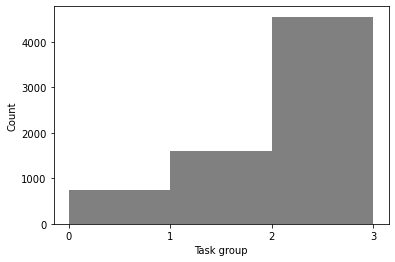

In [12]:
# Get new score distribution
score = df_score['task_label'].values
score = np.array(score, dtype=float)

# score distribution
counts, bin_edges = np.histogram(score,bins = bin_range)
fig, ax = plt.subplots()
ax.hist(score, bins = bin_range, histtype='bar', color = 'grey')
ax.set_xlabel(title_name)
ax.set_ylabel('Count')
ax.set_xticks(xtick_name)
# save figure
# plt.savefig(os.path.join(save_path,"Tremor_score_distribution"))
counts

In [14]:
# Up-sampling
upsampled_df_feature = pd.DataFrame()
upsampled_df_score = pd.DataFrame()
upsampled_df_meta = pd.DataFrame()

# upsample_size = 600
upsample_size = round(max(counts)/2)
# upsample_size = round(sum(counts)/2)
        
for c,s in zip(counts[0:4],range(4)):
#     if s == 3:
#         df_feature_group = df_feature.loc[score==s]
#         df_score_group = df_score.loc[score==s]
#         df_meta_group = df_meta.loc[score==s]
#         idx_list = df_feature_group.index.tolist()
#         resample_idx = resample(idx_list, replace=True, n_samples=upsample_size, random_state=27)
#         upsampled_feature_group = df_feature_group.loc[resample_idx]
#         upsampled_score_group = df_score_group.loc[resample_idx]
#         upsampled_meta_group = df_meta_group.loc[resample_idx]
#     else:
#         upsampled_feature_group = df_feature.loc[score==s]
#         upsampled_score_group = df_score.loc[score==s]
#         upsampled_meta_group = df_meta.loc[score==s]
        
    if c == max(counts):
        upsampled_feature_group = df_feature.loc[score==s]
        upsampled_score_group = df_score.loc[score==s]
        upsampled_meta_group = df_meta.loc[score==s]    
    else:
        df_feature_group = df_feature.loc[score==s]
        df_score_group = df_score.loc[score==s]
        df_meta_group = df_meta.loc[score==s]
        idx_list = df_feature_group.index.tolist()
        resample_idx = resample(idx_list, replace=True, n_samples=upsample_size, random_state=27)
        upsampled_feature_group = df_feature_group.loc[resample_idx]
        upsampled_score_group = df_score_group.loc[resample_idx]
        upsampled_meta_group = df_meta_group.loc[resample_idx]
        
    upsampled_df_feature = pd.concat([upsampled_df_feature, upsampled_feature_group])
    upsampled_df_score = pd.concat([upsampled_df_score, upsampled_score_group])
    upsampled_df_meta = pd.concat([upsampled_df_meta, upsampled_meta_group])


upsampled_df_feature = upsampled_df_feature.reset_index(drop=True)
upsampled_df_score = upsampled_df_score.reset_index(drop=True)
upsampled_df_meta = upsampled_df_meta.reset_index(drop=True)

print('upsampled features:' + str(upsampled_df_feature.shape))
print('upsampled scores:' + str(upsampled_df_score.shape))
print('upsampled meta:' + str(upsampled_df_meta.shape))

# Try other upsmapling methods:
# from imblearn.over_sampling import SMOTE

upsampled features:(9108, 2262)
upsampled scores:(9108, 12)
upsampled meta:(9108, 97)


In [15]:
df_feature = upsampled_df_feature
df_score = upsampled_df_score
df_meta = upsampled_df_meta

In [16]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0, solver = 'liblinear'),
    "KNN" : KNeighborsClassifier(),
#     "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
#     "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

# SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
#             'kernel': ['linear', 'rbf'],
#             'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [2, 4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
#     "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
#     "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

In [17]:
## sensor features
# Remove features with nan
df_feature2 = df_feature.dropna(axis=1)

# Remove features with zero variance
sel = VarianceThreshold(threshold=0.0001)
df_feature3 = sel.fit_transform(df_feature2)
filter3 = sel.get_support()
feature_names2 = df_feature2.columns
feature_names3 = feature_names2[filter3]
df_feature3 = pd.DataFrame(df_feature3, columns=feature_names3)

# Get scores
score = df_score['task_label']

# Univariate Selection
test = SelectKBest(score_func=f_classif, k=30)
df_feature4 = test.fit_transform(df_feature3, score)
filter4 = test.get_support()
feature_names4 = feature_names3[filter4]
df_feature4 = pd.DataFrame(df_feature4, columns=feature_names4)

# PCA
X_feature=df_feature4.values
pca = PCA(n_components=10)
X_new = pca.fit_transform(X_feature)

# ## clinical features
# df_meta2 = df_meta.dropna(axis=1)
# df_meta3 = sel.fit_transform(df_meta2)
# filter3 = sel.get_support()
# meta_names2 = df_meta2.columns
# meta_names3 = meta_names2[filter3]
# df_meta3 = pd.DataFrame(df_meta3, columns=meta_names3)

# # Univariate Selection
# test = SelectKBest(score_func=f_classif, k=20)
# df_meta4 = test.fit_transform(df_meta3, score)
# filter4 = test.get_support()
# meta_names4 = meta_names3[filter4]
# df_meta4 = pd.DataFrame(df_meta4, columns=meta_names4)

# # PCA
# X_meta=df_meta4.values
# pca = PCA(n_components=5)
# X_meta_new = pca.fit_transform(X_meta)

# Combine waveform feature with task code feature
# X_meta_new = df_meta.to_numpy()
# X_new = np.concatenate((X_feature_new, X_meta_new), axis=1)

# Train/Validation/Test Split
is_train = df_score['subject_id'].isin(sb_train).tolist()
is_val = df_score['subject_id'].isin(sb_val).tolist()
is_test = df_score['subject_id'].isin(sb_test).tolist()
is_train_val = df_score['subject_id'].isin(sb_train) | df_score['subject_id'].isin(sb_val)
is_train_val = is_train_val.tolist()

X_train_valid = X_new[is_train_val,:]
y_train_valid = score[is_train_val]
X_train = X_new[is_train,:]
y_train = score[is_train]
X_valid = X_new[is_val,:]
y_valid = score[is_val]
X_test = X_new[is_test,:]
y_test = score[is_test]

# Classifier evaluation
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(),
                           'Accuracy': np.zeros(len(classifiers)),
                           'F1_macro': np.zeros(len(classifiers)),
                           'F1_micro': np.zeros(len(classifiers)),
                           'F1_weighted': np.zeros(len(classifiers)),
                           'F1_0': np.zeros(len(classifiers)),
                           'F1_1': np.zeros(len(classifiers)),                               
                           'Precision_0': np.zeros(len(classifiers)),
                           'Precision_1': np.zeros(len(classifiers)),
                           'Recall_0': np.zeros(len(classifiers)),
                           'Recall_1': np.zeros(len(classifiers)),
                           'Training time': np.zeros(len(classifiers))})

for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    Accuracy = accuracy_score(y_valid, y_pred).round(2)
    F1_macro = f1_score(y_valid, y_pred, average = 'macro').round(2)
    F1_micro = f1_score(y_valid, y_pred, average = 'micro').round(2)
    F1_weighted = f1_score(y_valid, y_pred, average = 'weighted').round(2)
    F1_class = f1_score(y_valid, y_pred, average = None).round(2)
    Precision = precision_score(y_valid, y_pred, average = None).round(2)
    Recall = recall_score(y_valid, y_pred, average = None).round(2)                                         

    valid_scores.iloc[i,1]=Accuracy
    valid_scores.iloc[i,2]=F1_macro
    valid_scores.iloc[i,3]=F1_micro
    valid_scores.iloc[i,4]=F1_weighted
    valid_scores.iloc[i,5]=F1_class[0]
    valid_scores.iloc[i,6]=F1_class[1]
    valid_scores.iloc[i,7]=Precision[0]
    valid_scores.iloc[i,8]=Precision[1] 
    valid_scores.iloc[i,9]=Recall[0]
    valid_scores.iloc[i,10]=Recall[1]

    # Save trained model
    clf_best_params[key]=clf.best_params_

    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,11]=np.round((stop - start)/60, 2)


    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,11])
    print('')
    i+=1

# Select best classifier based on recall score for the positive class
best_recall_1 = max(valid_scores['Recall_1'])
best_clf = valid_scores['Classifer'].loc[valid_scores['Recall_1']==best_recall_1].values[0]
training_time = valid_scores['Training time'].loc[valid_scores['Recall_1']==best_recall_1].values[0]
clf_best_params = clf_best_params[best_clf]

clf_summary = pd.DataFrame({'title': [title_name],
         'max_sample_size': [max(counts)],
         'upsample_size': [upsample_size],
         'best_F1_weighted': [max(valid_scores['F1_weighted'])],            
         'best_recall_1': [best_recall_1],
         'best_clf': [best_clf],
         'clf_best_params': [clf_best_params],                         
         'valid_scores': [valid_scores]},
          index=[0])

Model: LogisticRegression
Training time (mins): 0.07

Model: KNN
Training time (mins): 0.01

Model: RandomForest
Training time (mins): 0.47

Model: XGBoost
Training time (mins): 1.44

Model: LGBM
Training time (mins): 0.24

Model: NaiveBayes
Training time (mins): 0.0



In [18]:
clf_summary

,title,max_sample_size,upsample_size,best_F1_weighted,best_recall_1,best_clf,clf_best_params,valid_scores
0,Task group,4554,2277,0.88,0.82,XGBoost,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est...",Classifer Accuracy F1_macro F1_...


In [ ]:
# save validation_summary
# save_file_path = os.path.join(save_path, save_name + '_validation.pkl')
# clf_summary.to_pickle(save_file_path)

In [19]:
clf_summary['valid_scores'].loc[0]

,Classifer,Accuracy,F1_macro,F1_micro,F1_weighted,F1_0,F1_1,Precision_0,Precision_1,Recall_0,Recall_1,Training time
0,LogisticRegression,0.80,0.78,0.80,0.80,0.76,0.74,0.92,0.83,0.65,0.67,0.07
1,KNN,0.82,0.81,0.82,0.82,0.79,0.77,0.82,0.75,0.76,0.79,0.01
2,RandomForest,0.88,0.87,0.88,0.88,0.82,0.86,0.90,0.92,0.75,0.81,0.47
3,XGBoost,0.88,0.87,0.88,0.88,0.85,0.86,0.93,0.91,0.78,0.82,1.44
4,LGBM,0.88,0.86,0.88,0.88,0.82,0.86,0.89,0.92,0.76,0.80,0.24
5,NaiveBayes,0.77,0.75,0.77,0.76,0.67,0.74,0.80,0.84,0.58,0.67,0.00


In [ ]:
clf_summary['valid_scores'].loc[1]

In [ ]:
clf_summary['valid_scores'].loc[2]

In [ ]:
clf_summary['valid_scores'].loc[3]

In [ ]:
# load validation score data
questions = ['tremor_score', 'is_tremor', 'is_sever_tremor']

df_valid = pd.DataFrame()
for q in questions:
    file_path = os.path.join(save_path, q + '_validation.pkl')
    df_valid_q = pd.read_pickle(file_path)
    df_valid = pd.concat([df_valid,df_valid_q])
df_valid = df_valid.reset_index(drop=True)

In [ ]:
df_valid

In [ ]:
df_valid['valid_scores'].iloc[4]

In [ ]:
df_valid_summary = df_valid[['title','task_group']].copy


In [ ]:
row = 0
clf_valid_scores = df_valid['valid_scores'].iloc[row]
# Select best F1 score
best_F1_score = max(clf_valid_scores['F1_weighted'])
# Select best classifier based on recall score for positive class
best_recall_1 = max(clf_valid_scores['Recall_1'])
best_clf = clf_valid_scores['Classifer'].loc[clf_valid_scores['Recall_1']==best_recall_1].values[0]
training_time = clf_valid_scores['Training time'].loc[clf_valid_scores['Recall_1']==best_recall_1]

In [ ]:
best_clf

In [ ]:
clf_valid_scores

In [ ]:
df_valid_summary = pd.DataFrame()
for row in range(len(df_valid)):
    clf_valid_scores = df_valid['valid_scores'].iloc[row]
    # Select best classifier based on recall score for positive class
    best_recall_1 = max(clf_valid_scores['Recall_1'])
    best_clf = clf_valid_scores['Classifer'].loc[clf_valid_scores['Recall_1']==best_recall_1].values[0]
    training_time = clf_valid_scores['Training time'].loc[clf_valid_scores['Recall_1']==best_recall_1].values[0]
    
    df_valid_row = pd.DataFrame({"title": df_valid['title'].iloc[row],
                                "task_group": df_valid['task_group'].iloc[row],
                                 "best_F1_score": max(clf_valid_scores['F1_weighted']),
                                 "best_recall_1": best_recall_1,
                                 "best_clf": best_clf,
                                 "training_time": training_time},
                               index = [row])
    df_valid_summary = pd.concat([df_valid_summary,df_valid_row])

In [ ]:
df_valid_summary

In [ ]:
df_valid_summary.drop([0,1,2,3])

# For feature engineering 

In [ ]:
# Train/Validation/Test Split
is_train = df_score['subject_id'].isin(sb_train).tolist()
is_val = df_score['subject_id'].isin(sb_val).tolist()
is_test = df_score['subject_id'].isin(sb_test).tolist()
is_train_val = df_score['subject_id'].isin(sb_train) | df_score['subject_id'].isin(sb_val)
is_train_val = is_train_val.tolist()

# df_feature_train = df_feature[is_train]
# df_score_train = df_score[is_train]
# df_feature_val = df_feature[is_val]
# df_score_val = df_score[is_val]
# df_feature_test = df_feature[is_test]
# df_score_test = df_score[is_test]

In [ ]:
# Remove features with nan
df_feature2 = df_feature.dropna(axis=1)

# Remove features with zero variance
sel = VarianceThreshold(threshold=0.0001)
df_feature3 = sel.fit_transform(df_feature2)
filter3 = sel.get_support()
feature_names2 = df_feature2.columns
feature_names3 = feature_names2[filter3]
df_feature3 = pd.DataFrame(df_feature3, columns=feature_names3)

# Get scores
score = df_score['newTremorLabel_GENEActivHand'].values
# score = df_score['tremor_GENEActivHand'].values
# score = df_score['tremor_PebbleHand'].values
score = np.array(score, dtype=float)

# Univariate Selection
test = SelectKBest(score_func=f_classif, k=10)
df_feature4 = test.fit_transform(df_feature3, score)
filter4 = test.get_support()
feature_names4 = feature_names3[filter4]
df_feature4 = pd.DataFrame(df_feature4, columns=feature_names4)

# PCA
X=df_feature4.values
pca = PCA(n_components=3)
X_new = pca.fit_transform(X)

# train/validation/test split
X_train_valid = X_new[is_train_val,:]
y_train_valid = score[is_train_val]
X_train = X_new[is_train,:]
y_train = score[is_train]
X_valid = X_new[is_val,:]
y_valid = score[is_val]
X_test = X_new[is_test,:]
y_test = score[is_test]

In [ ]:
fit = pca.fit(X)
np.cumsum(fit.explained_variance_ratio_)

# For test dataset

In [ ]:
# best classifiers
NB_best = GaussianNB(**clf_best_params["NaiveBayes"])
NB_best.fit(X_train_valid, y_train_valid)
y_pred = NB_best.predict(X_test)

In [ ]:
# best classifiers
LR_best = LogisticRegression(**clf_best_params["LogisticRegression"], verbose=False, random_state=0, solver = 'liblinear')
LR_best.fit(X_train_valid, y_train_valid)
y_pred = LR_best.predict(X_test)

In [ ]:
# best classifiers
RF_best = RandomForestClassifier(**clf_best_params["RandomForest"], verbose=False, random_state=0)
RF_best.fit(X_train_valid, y_train_valid)
y_pred = RF_best.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
Accuracy = accuracy_score(y_test, y_pred)
Precision = precision_score(y_test, y_pred, average = None)
Recall = recall_score(y_test, y_pred, average = None)
F1 = f1_score(y_test, y_pred, average = None)

In [ ]:
Accuracy

In [ ]:
Precision

In [ ]:
Recall

In [ ]:
F1

In [ ]:
F1_weighted = f1_score(y_test, y_pred, average = 'weighted')

In [ ]:
F1_weighted

In [ ]:
Recall[0]